<a href="https://colab.research.google.com/github/NasywaFebia12/Tugastaxi/blob/master/UAS_Big_Data_%26_Predictive_Analytics_Lanjut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proses Data dan Pre-processing

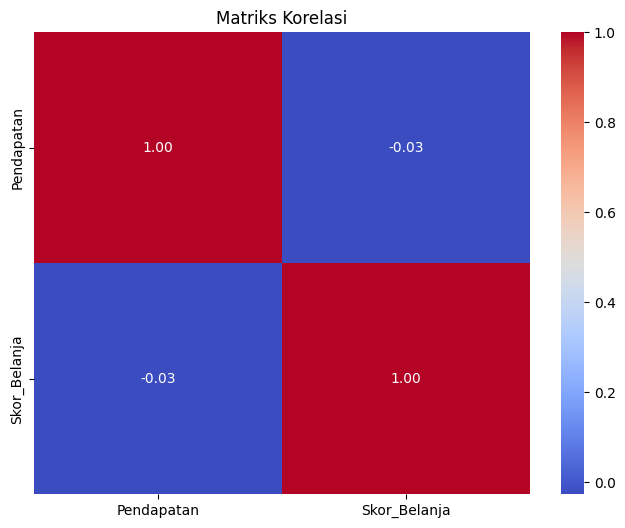

+------------+-------------+----+----------+------------+-----------+--------------------+
|ID_pelanggan|Jenis Kelamin|Umur|Pendapatan|Skor_Belanja|   features|     scaled_features|
+------------+-------------+----+----------+------------+-----------+--------------------+
|           1|    Laki-laki|  19|      15.0|        39.0|[15.0,39.0]|[0.60037011812071...|
|           2|    Laki-laki|  21|      15.0|        81.0|[15.0,81.0]|[0.60037011812071...|
|           3|    Perempuan|  20|      16.0|         6.0| [16.0,6.0]|[0.64039479266209...|
|           4|    Perempuan|  23|      16.0|        77.0|[16.0,77.0]|[0.64039479266209...|
|           5|    Perempuan|  31|      17.0|        40.0|[17.0,40.0]|[0.68041946720347...|
+------------+-------------+----+----------+------------+-----------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("SupermarketSegmentation").getOrCreate()

# Load data
data_path = "/content/sample_data/pelanggan_supermarket.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Rename columns
df = df.withColumnRenamed("Pendapatan pertahun (juta)", "Pendapatan") \
       .withColumnRenamed("Skor Belanja (1-100)", "Skor_Belanja")

# Drop missing values
df = df.dropna()

# Transform data types if necessary
df = df.withColumn("Pendapatan", col("Pendapatan").cast("float")) \
       .withColumn("Skor_Belanja", col("Skor_Belanja").cast("float"))

# Assemble features
vec_assembler = VectorAssembler(inputCols=["Pendapatan", "Skor_Belanja"], outputCol="features")
df_features = vec_assembler.transform(df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
df_scaled = scaler.fit(df_features).transform(df_features)
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseMatrix

# Menghitung matriks korelasi
correlation_matrix = Correlation.corr(df_features, "features").head()[0]

# Konversi matriks korelasi ke bentuk DenseMatrix
correlation_matrix = DenseMatrix.toArray(correlation_matrix)

# Membuat DataFrame untuk visualisasi matriks korelasi
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

columns = ["Pendapatan", "Skor_Belanja"]
correlation_df = pd.DataFrame(correlation_matrix, columns=columns, index=columns)

# Visualisasi matriks korelasi menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()

df_scaled.show(5)


2. Model Classification <br/>
Gradient Boost Tree (GBT)
python
Copy code


In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Membuat kolom label binary berdasarkan pendapatan
df_binary = df_scaled.withColumn("Pendapatan_Binary", (col("Pendapatan") >= 50).cast("int"))

# Periksa data hasil transformasi
df_binary.select("Pendapatan", "Pendapatan_Binary").show(5)

# Gradient Boosted Tree Classifier
gbt = GBTClassifier(labelCol="Pendapatan_Binary", featuresCol="scaled_features", maxIter=10)
gbt_model = gbt.fit(df_binary)
gbt_predictions = gbt_model.transform(df_binary)

# Evaluasi model menggunakan akurasi
evaluator = MulticlassClassificationEvaluator(labelCol="Pendapatan_Binary", metricName="accuracy")
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print(f"GBT Accuracy: {gbt_accuracy}")


+----------+-----------------+
|Pendapatan|Pendapatan_Binary|
+----------+-----------------+
|      15.0|                0|
|      15.0|                0|
|      16.0|                0|
|      16.0|                0|
|      17.0|                0|
+----------+-----------------+
only showing top 5 rows

GBT Accuracy: 0.995850622406639


Random Forest (Model Tambahan)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Buat kolom binary untuk label (misalnya, Pendapatan >= 50 adalah 1, selain itu 0)
df_binary = df_scaled.withColumn("Pendapatan_Binary", (col("Pendapatan") >= 50).cast("int"))

# Periksa data setelah transformasi
df_binary.select("Pendapatan", "Pendapatan_Binary").show(5)

# Random Forest Classifier
rf = RandomForestClassifier(labelCol="Pendapatan_Binary", featuresCol="scaled_features", numTrees=10)
rf_model = rf.fit(df_binary)
rf_predictions = rf_model.transform(df_binary)

# Evaluasi model menggunakan akurasi
evaluator = MulticlassClassificationEvaluator(labelCol="Pendapatan_Binary", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

+----------+-----------------+
|Pendapatan|Pendapatan_Binary|
+----------+-----------------+
|      15.0|                0|
|      15.0|                0|
|      16.0|                0|
|      16.0|                0|
|      17.0|                0|
+----------+-----------------+
only showing top 5 rows

Random Forest Accuracy: 0.995850622406639


3. Model Clustering (K-Means)

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# K-Means Clustering
kmeans = KMeans(k=4, featuresCol="scaled_features", predictionCol="prediction")
kmeans_model = kmeans.fit(df_scaled)
kmeans_predictions = kmeans_model.transform(df_scaled)

# Evaluate K-Means
clustering_evaluator = ClusteringEvaluator()
kmeans_silhouette = clustering_evaluator.evaluate(kmeans_predictions)
print(f"K-Means Silhouette Score: {kmeans_silhouette}")


K-Means Silhouette Score: 0.5692629512637629


Gaussian Mixture Model (Model Tambahan)

In [ ]:
from pyspark.ml.clustering import GaussianMixture

# Gaussian Mixture Model Clustering
gmm = GaussianMixture(k=4, featuresCol="scaled_features", predictionCol="prediction")
gmm_model = gmm.fit(df_scaled)
gmm_predictions = gmm_model.transform(df_scaled)

# Evaluate Gaussian Mixture Model
gmm_silhouette = clustering_evaluator.evaluate(gmm_predictions)
print(f"GMM Silhouette Score: {gmm_silhouette}")


GMM Silhouette Score: 0.060182849847821865


4. Evaluasi dan Pemilihan Model Terbaik
Setelah menjalankan keempat model, bandingkan performa berdasarkan:

* Classification: Akurasi dari Gradient Boost Tree (GBT) dan Random Forest.
* Clustering: Silhouette Score dari K-Means dan Gaussian Mixture Model.

5. Hyperparameter Tuning
(Hyperparameter Tuning untuk GBT)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Tambahkan kolom label binary
df_scaled = df_scaled.withColumn("Pendapatan_Binary", (col("Pendapatan") >= 50).cast("int"))

# Verifikasi kolom baru
df_scaled.select("Pendapatan", "Pendapatan_Binary").show(5)

# Gradient Boosted Tree Classifier
gbt = GBTClassifier(labelCol="Pendapatan_Binary", featuresCol="scaled_features")

# Parameter grid untuk hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

# Evaluator untuk mengevaluasi performa model
evaluator = MulticlassClassificationEvaluator(labelCol="Pendapatan_Binary", metricName="accuracy")

# Cross-validator
crossval = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Melakukan tuning
cv_gbt_model = crossval.fit(df_scaled)

# Model terbaik
best_gbt_model = cv_gbt_model.bestModel
best_gbt_accuracy = evaluator.evaluate(best_gbt_model.transform(df_scaled))
print(f"Best GBT Accuracy after tuning: {best_gbt_accuracy}")


+----------+-----------------+
|Pendapatan|Pendapatan_Binary|
+----------+-----------------+
|      15.0|                0|
|      15.0|                0|
|      16.0|                0|
|      16.0|                0|
|      17.0|                0|
+----------+-----------------+
only showing top 5 rows

Best GBT Accuracy after tuning: 0.995850622406639


Hyperparameter Tuning untuk K-Means

In [ ]:
# Hyperparameter Tuning for K-Means
silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(k=k, featuresCol="scaled_features", predictionCol="prediction")
    kmeans_model = kmeans.fit(df_scaled)
    kmeans_predictions = kmeans_model.transform(df_scaled)
    score = clustering_evaluator.evaluate(kmeans_predictions)
    silhouette_scores.append((k, score))

optimal_k = max(silhouette_scores, key=lambda x: x[1])
print(f"Optimal number of clusters: {optimal_k[0]} with silhouette score: {optimal_k[1]}")


Optimal number of clusters: 6 with silhouette score: 0.7083418505780484
